In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mt
from metpy.interpolate import interpolate_to_points
import scipy.optimize as spo
import time 

In [139]:
# creating the pulse field

def gen_field(dur_max, dur_step):
    pdur_i0 = ppau_i0 = np.arange(0, dur_max, dur_step)
    pdur_j, ppau_j = np.meshgrid(pdur_i0, ppau_i0)
    return pdur_j, ppau_j


In [140]:
#Plotting the data

def plot_field(pdur, ppau, res):
    plt.pcolor(pdur, ppau, res, cmap='Reds')
    plt.xlim(0, np.max(pdur))
    plt.ylim(0, np.max(ppau))
    plt.colorbar(label='Phonotaxis')
    plt.xlabel('Pulse [ms]')
    plt.ylabel('Pause [ms]')
    plt.show()

In [307]:
#filtering data to have similar chirp structure and eliminating redundancies in pulse pause and duration

def filter_data(x, dur_max):
    pd_df = x
    (uniq, freq) = (np.unique(pd_df.CDUR, return_counts=True))
    xa = np.array([uniq,freq])
    xa = xa.astype(int)

    jo = np.zeros(np.max(xa[0]))
    jo[xa[0]-1] = freq
    jo2 = []
    for i in range(30,len(jo)-30):
        jo2.append([i, np.sum(jo[i-30:i+30])])
    jo2 = np.array(jo2).T

    j = np.where(jo2 == np.max(jo2[1]))
    val = j[1][1] + 31

    x = pd_df.CDUR
    x1 = x>=(val-30)
    xa = pd_df[x1]
    x2 = xa.CDUR<=(val+30)
    xb = xa[x2]

    pd_df = xb
    (uniq, freq) = (np.unique(pd_df.CPAU, return_counts=True))
    xa = np.array([uniq,freq])
    xa = xa.astype(int)

    jo = np.zeros(np.max(xa[0]))
    jo[xa[0]-1] = freq
    jo2 = []
    for i in range(30,len(jo)-30):
        jo2.append([i, np.sum(jo[i-30:i+30])])
    jo2 = np.array(jo2).T

    j = np.where(jo2 == np.max(jo2[1]))
    val = j[1][1] + 31

    x = pd_df.CPAU
    x1 = x>=(val-30)
    xa = pd_df[x1]
    x2 = xa.CPAU<=(val+30)
    xb = xa[x2]

    dfa = pd.DataFrame([xb.PDUR, xb.PPAU, xb.rXY]).T
    dfx = dfa.groupby(['PPAU', 'PDUR']).mean().reset_index()
    
    check = dfx<=dur_max
    df_c = np.all(check,1)
    dfx = dfx[df_c]
    
    dfx = np.array([dfx.PDUR, dfx.PPAU, dfx.rXY]).T
    return dfx


In [330]:
#Importing data from file

def import_data(dur_max, dur_step):

    pd_df = pd.read_csv("dat/FIR.txt")
    df = filter_data(pd_df, dur_max)
    
    edg = [[0,0,0]]#, [0, dur_max-1, 0], [dur_max-1, dur_max-1, 0], [dur_max-1,0,0]]
    df = np.append(df, edg, axis = 0) #[20, 20, 0],
    
    df = df.T
    pdur = df[0]
    ppau = df[1]
    phonotaxis = df[2]

    np.random.seed(10)
    # need to jitter data points slightly for interp to work - probably a bug in metpy
    points = np.array([pdur + np.random.randn(*pdur.shape)/10000000, ppau + np.random.randn(*ppau.shape)/10000000]).T

    # make new grid of points to interpolate to
    pdur_i0 = ppau_i0 = np.arange(0, dur_max, dur_step)
    pdur_i, ppau_i = np.meshgrid(pdur_i0, ppau_i0)
    new_points = np.array([pdur_i, ppau_i]).T.reshape((-1, 2))

    # natural neighbour interpolation 
    ppf = interpolate_to_points(points, phonotaxis, new_points, interp_type='natural_neighbor')
    ppf[np.isnan(ppf)] = np.nanmean(ppf)
    ppf = np.maximum(ppf, 0)  # set neg vals to 0
    ppf = ppf.reshape((len(pdur_i), len(ppau_i))).T  # make interpolated ppf square
    
    ppf /= np.max(ppf)
    return ppf


In [333]:
#defining some global variables that are constant and used throughout the code

dur_max = 81  # ms
dur_step = 1  # ms
global pnt_ori, pdur_i, ppau_i
pnt_ori = import_data(dur_max, dur_step)
pnt_ori /= np.max(pnt_ori)
# print(pnt_ori)
pdur_i, ppau_i = gen_field(dur_max, dur_step)

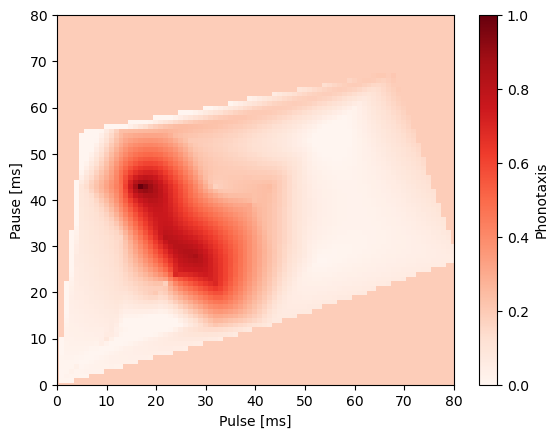

In [334]:
#For reference
plot_field(pdur_i, ppau_i, pnt_ori)

In [88]:
#generating the signal from the parameter duty cycle

def signal(idur, ipau, sf):
    sf = int(sf)
    unit = (sf/1000)
    dur = int(unit*idur)
    pau = int(unit*ipau)
    #print(dur, pau, unit)
    adur = np.ones(dur, dtype = int)
    apau = np.zeros(pau, dtype = int)
    aper = np.concatenate((adur,apau))
    sig2 = np.tile(aper, sf)
    if len(sig2)>sf:
        sig = sig2[0:sf]
    else:
        l = sf - len(sig2)
        sig3 = np.zeros(l, dtype = int)
        sig = np.concatenate((sig2, sig3))
    return sig

In [89]:
#The Gabor filter

def gabor(fr, sigma, phi, w, sf):
    border = int((3.5*sigma)) 
    t =  np.arange(-border, border, 1000/sf) #in ms
    gaussian = np.exp(-(t)**2/(2*sigma**2)) # in ms
    sinusoidal = np.sin(2*np.pi*(fr/1000)*t + phi) # in KHz, ms
    gbr =  gaussian * sinusoidal + w
    return gbr


In [90]:
#linear nonlinear filtering (including the integration)

def lin_nonlin(sig, gab, a1, b1):
    f1 = np.convolve(sig, gab) #linear filter
    
    g1 = 1/(1 + np.exp( -(a1 * f1) + b1)) # nonlinear sigmoid function

    #integral (which is basically summation)
    v1 = 0.001 * g1.sum()
    return v1

In [91]:
#extracting Phonotaxis value by pushing fabricated signal through filter

def phonotaxis(fr, sigma, phi, w, a1, b1, sf, t1, t2):
    sig1 = signal(t1, t2, sf)
    gab1 = gabor(fr, sigma, phi, w, sf)
    phntxs = lin_nonlin(sig1, gab1, a1, b1)
    return phntxs


In [92]:
#the entire model as a single function which is to be minimized 
#the function calculates the difference between the generated pulse-pause preference data and the actual experimental data imported earlier in the program.

def sig_diff(cfg):
    fr, sigma, ph, w, a1, b1 = cfg #unpacking the command from gods
    phi = np.pi * ph

    #generate field
    sf = 2000
    
    #calculating phonotaxis values
    phono = np.vectorize(phonotaxis)
    pnt = phono(fr, sigma, phi, w, a1, b1, sf, pdur_i, ppau_i)
    
    #normalization
    pnt = np.maximum(pnt, 0)
    if (np.max(pnt) - np.min(pnt)) > 0:
        pnt = (pnt - np.min(pnt))/(np.max(pnt) - np.min(pnt))
    else:
        pnt = (pnt - np.min(pnt))
    #RMS of difference
    diff = np.sqrt(np.mean((pnt - pnt_ori)**2))
    
    return diff

In [93]:
#redundant function for crossverification and plotting

def sig_diff2(cfg):
    fr, sigma, ph, w, a1, b1 = cfg #unpacking the command from gods
    phi = np.pi * ph

    #generate field
    sf = 2000
    
    #calculating phonotaxis values
    phono = np.vectorize(phonotaxis)
    pnt = phono(fr, sigma, phi, w, a1, b1, sf, pdur_i, ppau_i)
    
    #normalization
    pnt = np.maximum(pnt, 0)
    if (np.max(pnt) - np.min(pnt)) > 0:
        pnt = (pnt - np.min(pnt))/(np.max(pnt) - np.min(pnt))
    else:
        pnt = (pnt - np.min(pnt))
    #RMS of difference
    diff = np.sqrt(np.mean((pnt - pnt_ori)**2))
    
    return diff, pnt

0.2802975295264546


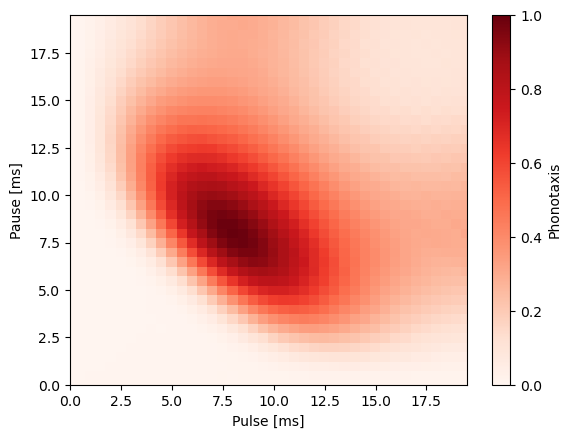

In [94]:
#setting initial values. and printing the start point of the minimize function present below
cfg = [62, 8, 0, 0, 0.05, 1]
y = sig_diff(cfg)
print(y)
xz = sig_diff2(cfg)
plot_field(pdur_i, ppau_i, xz[1])

In [80]:
# Example parameters for signal generation
# sf = 2000

# #PARAMETERS OF GABOR FUNCTION
# #frequency for the Gabor filter - INFLUENCES pulse period preference
# fr = 50 #in Hz
# #sharpness of tuning for pulse period
# sigma = 50 
# #phase shift - change the integer to change the phase 
# phi = np.pi * 0 
# #offset - INFLUENCES duty cycle preference
# w = 0

# #parameters for Lin_nonlinear
# a1 = 0.05 #slope/steepness of sigmoid
# b1 = 1 #1/2 of max of non linearity

# #pulse pause field sampling range and frequency(step)
# dur_max = 20  # ms
# dur_step = 0.5  # ms

In [82]:
#bounds of each parameter

b_fr = (0, 300)
b_sigma = (1, 101)
b_phi = (0, 2)
b_w = (-0.1, 0.1)
b_a1 = (0, np.inf)
b_b1 = (-np.inf, np.inf)

bnds = (b_fr, b_sigma, b_phi, b_w, b_a1, b_b1) #, b_dur_max, b_dur_step) #if necessary 


#Basin hopping minimization - to find the closest fit with the existing data without getting stuck in a local minima. , 'maxfev':1500  'options' : {"disp": True},  'bounds' : bnds, 
result = spo.basinhopping(sig_diff, cfg, niter = 30, minimizer_kwargs={'options' : {"disp": True}, 'bounds' : bnds,  'method' : 'L-BFGS-B'})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.54530D-01    |proj g|=  1.68425D-01

At iterate    1    f=  1.45032D-01    |proj g|=  1.01087D-01

At iterate    2    f=  1.44997D-01    |proj g|=  1.01031D-01

At iterate    3    f=  1.44996D-01    |proj g|=  1.70976D-02

At iterate    4    f=  1.44853D-01    |proj g|=  9.91331D-02

At iterate    5    f=  1.44783D-01    |proj g|=  9.91489D-02

At iterate    6    f=  1.44647D-01    |proj g|=  1.00689D-01

At iterate    7    f=  1.44585D-01    |proj g|=  1.00654D-01

At iterate    8    f=  1.44497D-01    |proj g|=  9.95335D-02

At iterate    9    f=  1.44424D-01    |proj g|=  9.97801D-02
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate   10    f=  1.44401D-01    |proj g|=  1.00236D-01

At iterate   11    f=  1.44396D-01    |proj g|=  9.97707D-02

At iterate   12 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         3 variables are exactly at the bounds

At iterate    0    f=  3.67234D-01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      0      1      0     0     0   0.000D+00   3.672D-01
  F =  0.36723421194453026     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         3 variables are exactly at the bounds

At iterate    0    f=  3.6


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         2 variables are exactly at the bounds

At iterate    0    f=  3.67234D-01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      0      1      0     0     0   0.000D+00   3.672D-01
  F =  0.36723421194453026     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         2 variables are exactly at the bounds

At iterate    0    f=  3.6


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   57    f=  1.36168D-01    |proj g|=  7.67772D-03

At iterate   58    f=  1.36163D-01    |proj g|=  5.73600D-02

At iterate   59    f=  1.36152D-01    |proj g|=  6.68720D-02

At iterate   60    f=  1.36151D-01    |proj g|=  1.47469D-02

At iterate   61    f=  1.36151D-01    |proj g|=  9.77976D-04

At iterate   62    f=  1.36151D-01    |proj g|=  3.57429D-03

At iterate   63    f=  1.36151D-01    |proj g|=  6.81355D-03

At iterate   64    f=  1.36151D-01    |proj g|=  1.24531D-02

At iterate   65    f=  1.36151D-01    |proj g|=  2.13450D-02

At iterate   66    f=  1.36151D-01    |proj g|=  3.59057D-02

At iterate   67    f=  1.36150D-01    |proj g|=  5.94262D-02

At iterate   68    f=  1.36149D-01    |proj g|=  9.78671D-02

At iterate   69    f=  1.36145D-01    |proj g|=  1.03796D-01

At iterate   70    f=  1.36136D-01    |proj g|=  1.03754D-01

At iterate   71    f=  1.36113D-01    |proj g|=  1.03611D-01

At iterate   72    f=  1.36055D-01    |proj g|=  1.03207D-01

At iter

/tmp/ipykernel_293/901067433.py:6: RuntimeWarning: overflow encountered in exp
  g1 = 1/(1 + np.exp( -(a1 * f1) + b1)) # nonlinear sigmoid function



At iterate   19    f=  2.39806D-01    |proj g|=  5.05231D-02

At iterate   20    f=  2.39656D-01    |proj g|=  7.57720D-02

At iterate   21    f=  2.39281D-01    |proj g|=  4.32482D-02

At iterate   22    f=  2.39091D-01    |proj g|=  7.78144D-02

At iterate   23    f=  2.38953D-01    |proj g|=  7.84963D-02

At iterate   24    f=  2.38342D-01    |proj g|=  7.75996D-02

At iterate   25    f=  2.35949D-01    |proj g|=  9.31627D-02

At iterate   26    f=  2.35902D-01    |proj g|=  7.50083D-02

At iterate   27    f=  2.35775D-01    |proj g|=  6.07366D-02

At iterate   28    f=  2.35761D-01    |proj g|=  7.46416D-02

At iterate   29    f=  2.35745D-01    |proj g|=  7.45798D-02

At iterate   30    f=  2.35730D-01    |proj g|=  3.12341D-02

At iterate   31    f=  2.35718D-01    |proj g|=  7.43260D-02

At iterate   32    f=  2.35707D-01    |proj g|=  3.79608D-02

At iterate   33    f=  2.35705D-01    |proj g|=  1.58789D-02

At iterate   34    f=  2.35704D-01    |proj g|=  5.14568D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  6.69724D-01    |proj g|=  2.00000D-01

At iterate    1    f=  2.35249D-01    |proj g|=  7.60103D-02

At iterate    2    f=  2.35039D-01    |proj g|=  1.10330D-01

At iterate    3    f=  2.34993D-01    |proj g|=  5.66987D-02

At iterate    4    f=  2.34985D-01    |proj g|=  7.42195D-02

At iterate    5    f=  2.34981D-01    |proj g|=  7.42077D-02

At iterate    6    f=  2.34979D-01    |proj g|=  2.05917D-02

At iterate    7    f=  2.34979D-01    |proj g|=  4.82673D-02

At iterate    8    f=  2.34979D-01    |proj g|=  2.97991D-02

At iterate    9    f=  2.34978D-01    |proj g|=  3.82052D-03

At iterate   10    f=  2.34978D-01    |proj g|=  2.39334D-03

At iterate   11    f=  2.34978D-01    |proj g|=  1.34116D-02

At iterate   12    f=  2.34977D-01    |proj g|=  4.57946D-02

At iterate   13    f=  2.3


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   18    f=  2.36445D-01    |proj g|=  1.32719D-01

At iterate   19    f=  2.36428D-01    |proj g|=  3.27005D-02

At iterate   20    f=  2.36428D-01    |proj g|=  1.09331D-02

At iterate   21    f=  2.36428D-01    |proj g|=  5.29057D-03

At iterate   22    f=  2.36428D-01    |proj g|=  2.92241D-03

At iterate   23    f=  2.36428D-01    |proj g|=  2.92699D-03

At iterate   24    f=  2.36427D-01    |proj g|=  5.76319D-03

At iterate   25    f=  2.36426D-01    |proj g|=  1.14783D-02

At iterate   26    f=  2.36411D-01    |proj g|=  1.06514D-01
  ys=-1.273E-05  -gs= 9.552E-06 BFGS update SKIPPED

At iterate   27    f=  2.36410D-01    |proj g|=  1.10756D-01
  ys=-1.502E-07  -gs= 1.694E-06 BFGS update SKIPPED

At iterate   28    f=  2.36410D-01    |proj g|=  1.01429D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = num


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  3.00009D-01    |proj g|=  2.00000D-01

At iterate    1    f=  2.83308D-01    |proj g|=  1.80872D-01

At iterate    2    f=  2.36558D-01    |proj g|=  9.66525D-02

At iterate    3    f=  2.36325D-01    |proj g|=  6.74989D-02

At iterate    4    f=  2.36266D-01    |proj g|=  1.47670D-01

At iterate    5    f=  2.36264D-01    |proj g|=  1.32688D-01

At iterate    6    f=  2.36247D-01    |proj g|=  7.74536D-02

At iterate    7    f=  2.36204D-01    |proj g|=  6.73924D-02

At iterate    8    f=  2.36198D-01    |proj g|=  6.73618D-02

At iterate    9    f=  2.36192D-01    |proj g|=  1.09032D-01

At iterate   10    f=  2.36191D-01    |proj g|=  2.02799D-02

At iterate   11    f=  2.36191D-01    |proj g|=  2.80269D-02

At iterate   12    f=  2.36191D-01    |proj g|=  8.40885D-03

At iterate   13    f=  2.3

                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 0.13476700429289817
                          x: [ 5.979e+01  1.118e+01  2.000e+00  2.166e-05
                               1.119e-01  2.651e-03]
                        nit: 30
      minimization_failures: 0
                       nfev: 11074
                       njev: 1582
 lowest_optimization_result:  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
                              success: True
                               status: 0
                                  fun: 0.13476700429289817
                                    x: [ 5.979e+01  1.118e+01  2.000e+00
                                         2.166e-05  1.119e-01  2.651e-03]
                                  nit: 89
                                  jac: [-2.550e-04 -5.247e-04 -2.600e-01
                                         3.554e+00 -4.263e-05 -4.

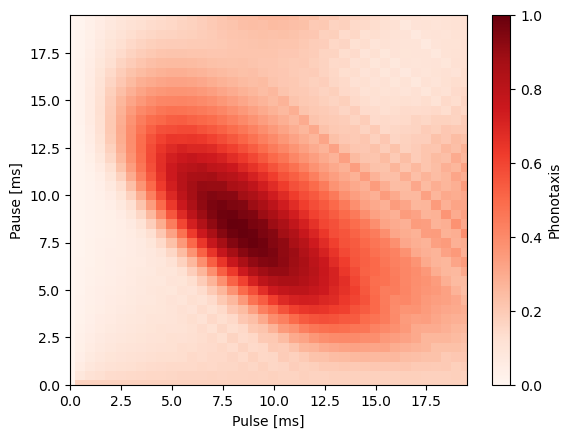

In [84]:
#Printing the result and the closest fit result generated from the model. 

print(result)
xe = sig_diff2(result.x)
plot_field(pdur_i, ppau_i, xe[1])

In [223]:
# cfg1 = [1,0,0]
# vals = []
# for i in range(100, 160):
#     print(i)
#     for j in range(10, 35):
#         cfg = [i, j, 0, 0, 0.05, 1]
#         x = sig_diff(cfg)
#         vals.append(x)
#         if cfg1[0] > x:
#             cfg1 = [x, i, j]
    
# print(cfg1)
# plt.plot(vals)
# plt.show()